In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from scipy.stats import itemfreq

## First Approach - PCA and SAX

In [2]:
#basic preprocessing
#load data
normal_data= pd.read_csv('BATADAL_dataset03.csv')
normal_data.DATETIME = pd.to_datetime(normal_data['DATETIME'])
normal_data.set_index('DATETIME', inplace = True)
attack_data = pd.read_csv('BATADAL_dataset04.csv', index_col='DATETIME')
dataset=pd.read_csv('BATADAL_dataset04.csv')
dataset.columns = dataset.columns.str.strip()

#columns names contain blank spaces which have to be removed
strip = lambda container: map(lambda element: element.strip(), container)
attack_data.columns = strip(attack_data.columns.tolist())
normal_data.columns = strip(normal_data.columns.tolist())

#remove labels in normal data
del normal_data['ATT_FLAG']


#Normalize trainset to make them zero-mean which is necessary for pca to work properly
normalize = StandardScaler()
normalized_train = normalize.fit_transform(normal_data)
print(normalized_train.shape)

(8761, 43)


In [3]:
##############
####PCA
#############

pca = PCA(n_components=normalized_train.shape[1])
normalized_train_transformed = pca.fit_transform(normalized_train)
normalized_train_transformed.shape

(8761, 43)

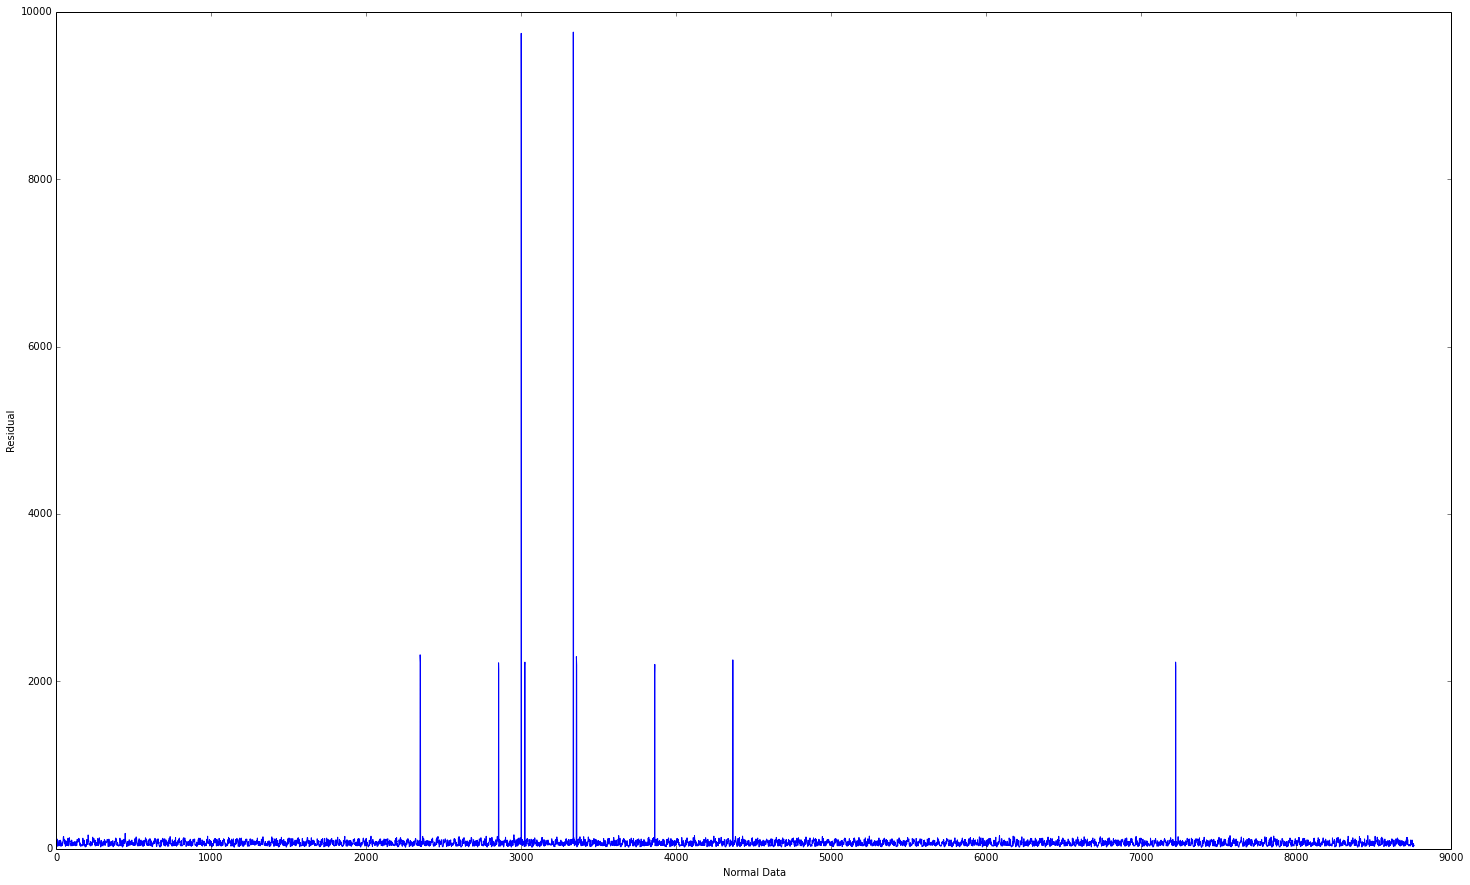

In [4]:
#investigate if there exist abnormalies in the normal data
normalized_train_reconstructed = pca.inverse_transform(normalized_train_transformed)
residual_pca1 = normalized_train_transformed - normalized_train_reconstructed
residual_pca2 = np.square(residual_pca1)
residual_pca = residual_pca2.sum(axis=1) 

figure, ax = plt.subplots(figsize=[25,15])
plt.xlabel('Normal Data')
plt.ylabel('Residual')
plt.figure(figsize=[25,10])
ax.plot(residual_pca)

In [5]:
#from the figure above we see that there are some extremely large values in the normal dataset
#we have to remove the abnormalies found and then tune the parameters
max_index = np.argmax(residual_pca)
#as can be seen found the above graph the values higher than approximately 1000 it is an outlier
kati = np.where(residual_pca >1000)
index = kati[0]
print('before', normal_data.shape)
for i in index:
    row = normal_data.iloc[[i]]
    normal_data = normal_data.drop(row.index)
print('after', normal_data.shape)
no_attack = normal_data
attack= attack_data

('before', (8761, 43))
('after', (8741, 43))


In [6]:
#first we load the necessary function for SAX

def znormalization(ts):
    """
    ts - each column of ts is a time series (np.ndarray)
    """
    mus = ts.mean(axis = 0)
    stds = ts.std(axis = 0)
    return (ts - mus) / stds

def paa_transform(data, n_pieces):
    """
    ts: the columns of which are time series represented by e.g. np.array
    n_pieces: M equally sized piecies into which the original ts is splitted
    """
    splitted = np.array_split(data, n_pieces) ## along columns as we want
    return list(map(lambda xs: xs.mean(axis = 0), splitted))

def sax_transform(dat,alphabet):
    from scipy.stats import norm
    alphabet_sz = len(alphabet)
    data=dat
    thrholds = norm.ppf(np.linspace(1./alphabet_sz,1-1./alphabet_sz,alphabet_sz-1))
    for indx, i in enumerate(data):
        temp=min(enumerate(thrholds), key=lambda x: abs(x[1]-i))
        if i< temp[1]:
            data[indx]=alphabet[temp[0]]
        else:
            data[indx]=alphabet[temp[0]+1]
    return data

def n_grams(data):
    length=len(data)
    bigrams=[]
    for i in range(0,length):
        if i<length-2:
            bigram=data[i]+data[i+1]+data[i+2]
            bigrams.append(bigram)
    return bigrams

In [7]:
#we construct the models for each signal seperately
signals= ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1',
       'F_PU2', 'F_PU3', 'F_PU4',
       'F_PU5', 'F_PU6', 'F_PU7', 'F_PU8',
        'F_PU9',  'F_PU10',  'F_PU11',
       'S_PU11', 'F_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256',
       'P_J289', 'P_J415', 'P_J302', 'P_J306', 'P_J307', 'P_J317',
       'P_J14', 'P_J422']
all_signals=[]
for sign in signals:
    signal_train=no_attack[sign]
    normalized_data=znormalization(signal_train)
    paa_form=paa_transform(normalized_data,116)
    sax_data=sax_transform(paa_form,'abcd')
    sax_data=''.join(sax_data)
    trigrams=n_grams(sax_data)
    trigrams_freq=itemfreq(trigrams)
    signal_test=attack[sign]
    normalized_data_test=znormalization(signal_test)
    paa_form_test=paa_transform(normalized_data_test,116)
    sax_data_test=sax_transform(paa_form_test,'abcd')
    sax_data_test=''.join(sax_data_test)
    trigrams_test=n_grams(sax_data_test)
    trigrams_freq_test=itemfreq(trigrams_test)
    anomalies=[]
    for i in trigrams_freq_test:
        if i[0] not in trigrams_freq:
            anomalies.append(i[0])
    for i in enumerate(trigrams_test):
        if i[1] in anomalies:
            signal_bottom=i[0]*36
            signal_top=signal_bottom+36
            all_signals.append(i[0])

In [8]:
tp=0
fp=0
tn=0
fn=0
final=[]
positions=[]
tot=set(all_signals)
for i in tot:
    if(all_signals.count(i)>1):
        final.append(i)
for i in final:
    signal_bottom=i*36
    signal_top=signal_bottom+36
    positions.append([signal_bottom,signal_top])
    for j in range(signal_bottom,signal_top): 
        if dataset.ATT_FLAG[j]==1:
            tp+=1
        else:
            fp+=1
tn=dataset.loc[dataset.ATT_FLAG==-999].shape[0]-fp
fn=dataset.loc[dataset.ATT_FLAG==1].shape[0]-tp
Accuracy=100.0*(tp+tn)/(tp+tn+fp+fn)
Precision=100.0*tp / (tp + fp)
Recall = 100.0*tp / (tp + fn)
F_score = 100.0*2*tp /(2*tp + fp + fn)
print ("TP:", tp)
print ("FP:", fp)
print("Accuracy: %.2f" % Accuracy)
print("Precision: %.2f" % Precision)
print("Recall: %.2f" %Recall)
print("F_score: %.2f" % F_score)

('TP:', 203)
('FP:', 589)
Accuracy: 85.52
Precision: 25.63
Recall: 92.69
F_score: 40.16


## Second Approach - Majority voting to decide if attack

We have stored the results of each model in a csv file. The csv files of ARMA and SAX contain the results of the combined individual models of each signal. We will start our approach by loading these files. Next for each data entry we will search how many models out of three have marked it as attack. If two models of all of them have predicted it is an attack it will be marked as it, otherwise it will be normal.

In [9]:
pca_predicted_labels = pd.read_csv('pca_predicted_labels.csv')
arma_predicted_labels = pd.read_csv('new.csv')
sax_predicted_labels = pd.read_csv('sax_predictions.csv')
attack_data = pd.read_csv('BATADAL_dataset04.csv')
attack_data.columns = attack_data.columns.str.strip()

In [10]:
#keep the labels separetaly and remove them from the set
true_labels = attack_data['ATT_FLAG']
del attack_data['ATT_FLAG']

In [11]:
predicted_labels = np.zeros(attack_data.shape[0])
labels = []
for idx, item in attack_data.iterrows():
    labels = []
    labels.append(pca_predicted_labels['0'][idx])
    labels.append(arma_predicted_labels['ATT_FLAG'][idx])
    labels.append(sax_predicted_labels['0'][idx])
#     print(labels,labels.count(1))
    if labels.count(1) >1:
        predicted_labels[idx] = 1
    else:
        predicted_labels[idx] = -999


In [12]:
tn, fp, fn, tp=confusion_matrix(true_labels, predicted_labels).ravel()
print(tp,fn,fp,tn)

(86, 133, 17, 3941)


In [13]:
Accuracy=100.0*(tp+tn)/(tp+tn+fp+fn)
Precision=100.0*tp / (tp + fp)
Recall = 100.0*tp / (tp + fn)
F_score = 100.0*2*tp /(2*tp + fp + fn)
print("Majority voting for all three models")
print ("TP:", tp)
print ("FP:", fp)
print("Accuracy: %.2f" % Accuracy)
print("Precision: %.2f" % Precision)
print("Recall: %.2f" %Recall)
print("F_score: %.2f" % F_score)

Majority voting for all three models
('TP:', 86)
('FP:', 17)
Accuracy: 96.41
Precision: 83.50
Recall: 39.27
F_score: 53.42
